In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Fraud.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldBalanceOrig,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newBalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldBalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newBalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [4]:
pd.crosstab(df.isFraud,df.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


## 1. Data cleaning including missing values, outliers and multi-collinearity.

In [5]:
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


We know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X.

In [6]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

### NaNs?

In [7]:
X.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

We can see, there are no NaNs.

Converting some columns to numeric.

In [8]:
X['step'] = pd.to_numeric(X['step'])
X['newBalanceOrig'] = pd.to_numeric(X['newBalanceOrig'])

### Outliers?

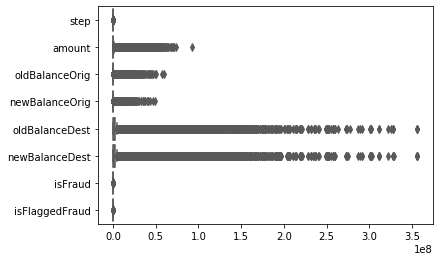

In [9]:
ax = sns.boxplot(data=X, orient="h", palette="Set2")
plt.show()

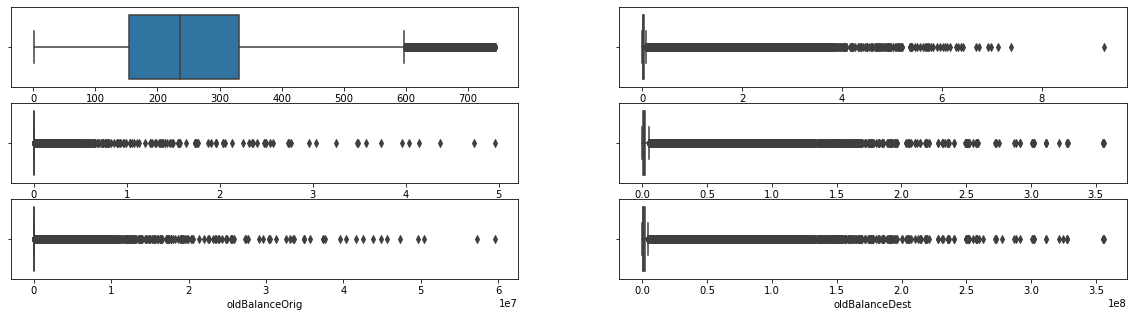

In [10]:
fig, ax =plt.subplots(3,2, figsize=(20,5))
sns.boxplot(X['step'], ax=ax[0,0])
sns.boxplot(X['amount'], ax=ax[0,1])
sns.boxplot(X['newBalanceOrig'], ax=ax[1,0])
sns.boxplot(X['newBalanceDest'], ax=ax[1,1])
sns.boxplot(X['oldBalanceOrig'], ax=ax[2,0])
sns.boxplot(X['oldBalanceDest'], ax=ax[2,1])
fig.show()

Removing outliers.

In [11]:
# While using lower quantile = 0.10, there were outliers so I have used lower quantile = 0.12.
X['amount'] = X['amount'][X['amount'].between(X['amount'].quantile(.0), X['amount'].quantile(.88))]

# From the boxplot we can see that upper limit for 'step' is approx 595.
X['step'] = X[(X['step'] <= 595)]

X['newBalanceOrig'] = X[(X['newBalanceOrig'] <= 1)]

X['newBalanceDest'] = X['newBalanceDest'][X['newBalanceDest'].between(X['newBalanceDest'].quantile(.0), X['newBalanceDest'].quantile(.77))]

X['oldBalanceOrig'] = X['oldBalanceOrig'][X['oldBalanceOrig'].between(X['oldBalanceOrig'].quantile(.0), X['oldBalanceOrig'].quantile(.75))]

X['oldBalanceDest'] = X['oldBalanceDest'][X['oldBalanceDest'].between(X['oldBalanceDest'].quantile(.0), X['oldBalanceDest'].quantile(.75))]

In [12]:
X['isFraud'].unique()

array([1, 0], dtype=int64)

In [14]:
Y = X['isFraud']
del X['isFraud']

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

We have several transactions with zero balances in both receiver and sender account before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent compared to genuine transactions.

In [15]:
# Dropping irrelevant columns.
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & (Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & (XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.2570315353707537

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.000609297819560958


Since, the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable ML algorithm detecting fraud.

In [16]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), ['oldBalanceDest', 'newBalanceDest']] = - 1

We also have several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent compared to genuine transactions. Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

In [17]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

By the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, if we create 2 new columns recording errors in the originating and destination accounts for each transaction. This can make our ML model more efficient.

In [18]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

### Multicollinearity?

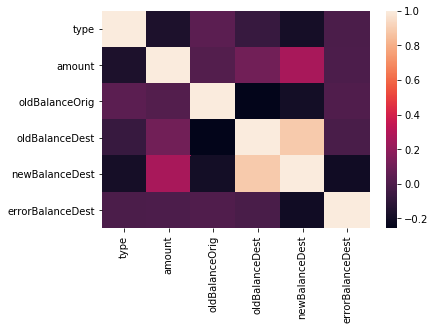

In [19]:
sns.heatmap(X.corr())
plt.show()

**How to Deal with Multicollinearity:-**

- Remove some of the highly correlated independent variables.

- Linearly combine the independent variables, such as adding them together.


We can observe that, 'oldBalanceOrig' & 'newBalanceOrig' are highly correlated.

To make our prediction more accurate, we are dropping one of the independent variable.

In [20]:
X.drop(['oldBalanceOrig'], axis = 1, inplace=True)

In [21]:
X['step'] = pd.to_numeric(X['step'])
X['newBalanceOrig'] = pd.to_numeric(X['newBalanceOrig'])
X['errorBalanceOrig'] = pd.to_numeric(X['errorBalanceOrig'])

# Splitting data into train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

Training XGBClassifier.

In [23]:
weights = (Y == 0).sum() / (Y == 1).sum()
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
clf.fit(X_train, Y_train)

[13:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=336.3199805186899, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix

def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [25]:
print('AUPRC = {}'.format(average_precision_score(Y_test, clf.predict_proba(X_test)[:,1])))

AUPRC = 0.782800062284589


**We can see that, we are getting very low accuracy rate/score, let us see what happens if we don't treat the outliers.**

In [26]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

Y = X['isFraud']
del X['isFraud']

X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), ['oldBalanceDest', 'newBalanceDest']] = - 1

X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

X.drop(['oldBalanceOrig'], axis = 1, inplace=True)

X['step'] = pd.to_numeric(X['step'])
X['newBalanceOrig'] = pd.to_numeric(X['newBalanceOrig'])
X['errorBalanceOrig'] = pd.to_numeric(X['errorBalanceOrig'])

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

In [28]:
weights = (Y == 0).sum() / (Y == 1).sum()
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4, enable_categorical=True)
clf.fit(X_train, Y_train)

print('AUPRC = {}'.format(average_precision_score(Y_test, clf.predict_proba(X_test)[:,1])))

[13:37:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9981054545333177


**We can see, we are getting a better accuracy score when we are not treating the outliers.**

## 2. Describe your fraud detection model in elaboration.

I have used XGBClassifier for this case because of the following reasons:
- It is faster than Gradient Boosting.
- It supports regularization.
- It is designed to handle missing data with its in-build features.

Steps I have done before and in training of model are described below:
- After observing that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. I have assembled only the corresponding data in X.
- Checked for null values. There are no NaNs.
- Plotted boxplot for observing outliers(if any) and removed those outliers using the concept of upper and lower quantile and finding the upper limit using boxplot.
- Binary-encoding of 'type' column.
- Observing that data has several transactions with zero balances in both receiver and sender account before and after a non-zero amount is transacted.
- Since, the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable ML algorithm detecting fraud.
- We also have several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent compared to genuine transactions. Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.
- We also have several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent compared to genuine transactions. Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.
- By the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, if we create 2 new columns recording errors in the originating and destination accounts for each transaction. This can make our ML model more efficient.
- Because of multi-colliniearity I have dropped 'oldBalanceOrig'.
- Converted 'step', 'newBalanceOrig' and 'errorBalanceOrig' to numeric data type.
- Splitting the data in train and test sets with a ratio of 8:2 (train:test) and fixed random state to an integer.
- I have fixed max_depth = 3, which means the distance between root node and the leaf node is 3. scale_pos_weight is the ratio of number of negative class to the positive class. n_jobs is the number of parallel threads used to run XGBClassifier.
- I have used average_precision_score to find the score of model.
- But, since the model was performing not very good, I trained the model without treating the outliers and now it has a very good accuracy and I have also used many other tools/methods to show the performance of model.

I have selected features/independent variables for training model with the points described in Question 3(below) and using the feature_importances_, I have shown the importance of each feature used in training(in Question 5).

## 3. How did you select variables to be included in the model?

- Some variables/columns (like- nameOrig & nameDest) can be observed and concluded to be useless.

- Using correlation matrix and treating multi-collinearity.

- Created new columns (like- newBalanceOrig & errorBalanceOrig) for boosting accuracy/performance.

## 4. Demonstrate the performance of the model by using best set of tools.

In [29]:
model_result(clf, X_test, Y_test)

AUPRC : 0.9981054545333177
F1 - score : 0.9898929845422116
Confusion_matrix : 
[[552383     29]
 [     5   1665]]
accuracy_score
0.9999386372414192
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.98      1.00      0.99      1670

    accuracy                           1.00    554082
   macro avg       0.99      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



## 5. What are the key factors that predict fraudulent customer?

In [30]:
importance = clf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00210
Feature: 1, Score: 0.00028
Feature: 2, Score: 0.01312
Feature: 3, Score: 0.08750
Feature: 4, Score: 0.01426
Feature: 5, Score: 0.00074
Feature: 6, Score: 0.87572
Feature: 7, Score: 0.00629


In [31]:
X.columns

Index(['step', 'type', 'amount', 'newBalanceOrig', 'oldBalanceDest',
       'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

We can see, 'errorBalanceOrig', 'newBalanceOrig', 'amount' and 'oldBalanceDest' are the key factors/variables that are helping in predicting fradulent customers.

## 6. Do these factors make sense? If yes, How? If not, How not?

Yes, the key factors/features make sense because, it is important for someone who is finding fraud customers to have knowledge of 'amount' that was transacted, new balance after the transaction, balance in the receiver's bank account before the transaction and error occuring (if any) in sender's account balance.

## 7. What kind of prevention should be adopted while company update its infrastructure?

- **Know Your Employees:** Fraud perpetrators often display behavioral traits that can indicate the intention to commit fraud. Observing and listening to employees can help you identify potential fraud risk. It is important for management to be involved with their employees and take time to get to know them. Often, an attitude change can clue you into a risk.

- **Make Employees Aware/Set Up Reporting System:** Awareness affects all employees. Everyone within the organization should be aware of the fraud risk policy including types of fraud and the consequences associated with them. Those who are planning to commit fraud will know that management is watching and will hopefully be deterred by this.

- **Implement Internal Controls:** Internal controls are the plans and/or programs implemented to safeguard your company’s assets, ensure the integrity of its accounting records, and deter and detect fraud and theft.

- **Hire Trustworthy Experts:** Many of the people working for your company, including Certified Fraud Examiners (CFE), Certified Public Accountants (CPA), and CPAs who are Certified in Fraud Forensics (CFF) can all play important roles in establishing antifraud policies and procedures.

## 8. Assuming these actions have been implemented, how would you determine if they work?

One can examine whether the implemented preventions are efficient or not by observing the **count** and **trend** of fraud happening.